In [1]:
import torch
import torch.nn as nn
import lightning as L

In [2]:
image_dim = 256
image_channels = 3

# Dataset and Objective
The images are 3x256x256 JPEGS. There are 300 Monet paintings and 7038 real world images.

The task is to use a GAN to generate Monet-like paintings from real world images.

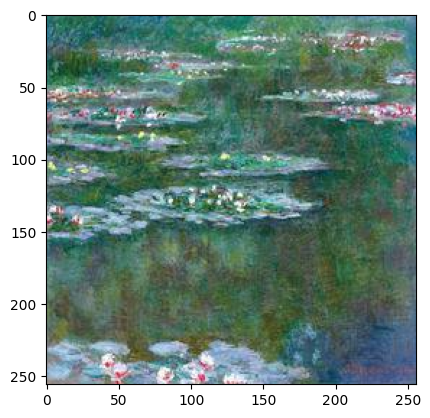

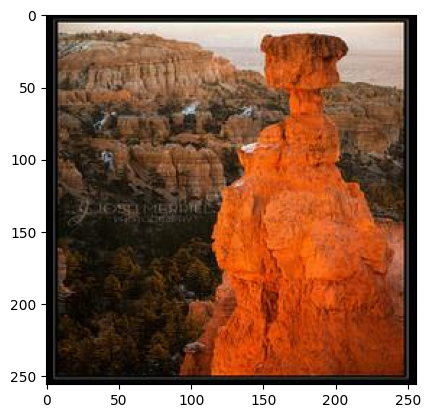

In [3]:
# print example images
monet_dir = "monet_jpg"
photo__dir = "photo_jpg"

from display_random_image import display_random_image

display_random_image(monet_dir)
display_random_image(photo__dir)